# Parameter selection through Bayesian optimization

This chapter discusses the feature to use (parallel) Bayesian optimization for selecting transport coefficients to fit experimental profiles.

## TOC:
* [Introduction](#intro)
* [Set up a UEDGE case](#set_up_case)
* [Define criteria of Bayesian optimization](#define_criteria)
* [Begin Bayesian optimization](#bo)
* [Post analysis](#analysis)

## Introduction<a class="anchor" id="intro"></a>

In UEDGE transport code, the perpendicular transport coefficients, such as `bbb.kye_use` and `bbb.kyi_use`, has to be defined by user before calculation. Those coefficients are usually chosen such that the mid-plane profiles, such as electron, ion temperature and density, fit the experimental measurement. Usually, the process of choosing appropriate transport coefficients is done by hand, which is not very convenient. So relief this burden, to some extent at least, `UETOOLS` has implemented a feature that uses Bayesian optimization to choose the best transport coefficients.

Bayesian optimization is a black-box derivative-free global optimization method that solves the problem
\begin{align}
\underset{x\in A}{\mathrm{min}}\, f(x),
\end{align}
where $x$ could be treated as the transport coefficients and $f(x)$ could be used as a loss function quantifying the discrepancy between `UEDGE` results and experimental profiles. Roughly speaking, the general procedures of Bayesian optimization can be illustrated as follows:

1. Observe $N$ points $\{x_i, f(x_i)\}$ as initial guess;
2. Fit all data available using a surrogate model, usually a Gaussian Process (GP) regression;
3. Find the maximizer $x^*$ of an acquisition function, which, intuitively, is most promising to be the minimum of $f(x)$ based on current data;
4. Observe new point at $\{x^*, f(x^*)\}$, update the surrogate model, acquisition function, and continue.

Detailed introduction to Bayesian optimization can be found in the following references:

[1] Garnett, Roman. [Bayesian optimization](https://doi.org/10.1017/9781108348973). Cambridge University Press, 2023.

[2] Frazier, Peter I. [arXiv:1807.02811](https://arxiv.org/abs/1807.02811) (2018).

[3] Brochu, Eric, et. al. [arXiv:1012.2599](https://arxiv.org/abs/1012.2599) (2010).

This chapter will discuss how to use Bayesian optimization method in `UETOOLS` as a black-box function.

Before moving on to the usage, there are two python packages needed for Bayesian optimiation:

- [`scikit-learn`](https://scikit-learn.org/stable/): Used to define the kernerls of Gaussian processes;

- [`bayesian-optimization`](https://github.com/bayesian-optimization/BayesianOptimization): Used as the core function to run Bayesian optimization. 

## Set up a UEDGE case <a class="anchor" id="set_up_case"></a>

In this chapter, we demonstrate the usage of Bayesian optimization in the simplest example. Here, we ignore all but the electron temperature equation, which is:
\begin{align}
\partial_\parallel (\kappa_\parallel \partial_\parallel T_e ) + 
\partial_\perp( n_e \chi_\perp \partial_\perp T_e) = 0,
\end{align} 
where the parallel diffusion is assumed to be Spitzer $\kappa_\parallel \sim T_e^{5/2}$, but the perpendicular transport coefficients $\chi_\perp$ is an unknown quantity to be determined by Bayesian optimization. Such a case has been set up in `UETOOLS`, where the related files are provided.

UEDGE configuration file /home/fu9/.uetoolsrc read.
No diffusivity-file supplied: reading from save-file "initial_profile"
  User-specified diffusivities read from HDF5 file "initial_profile"
UETOOLS-style save successfully restored from initial_profile

*** UEDGE arrays populated: Case appears converged ***
fnrm without preconditioning: 4.39e-04



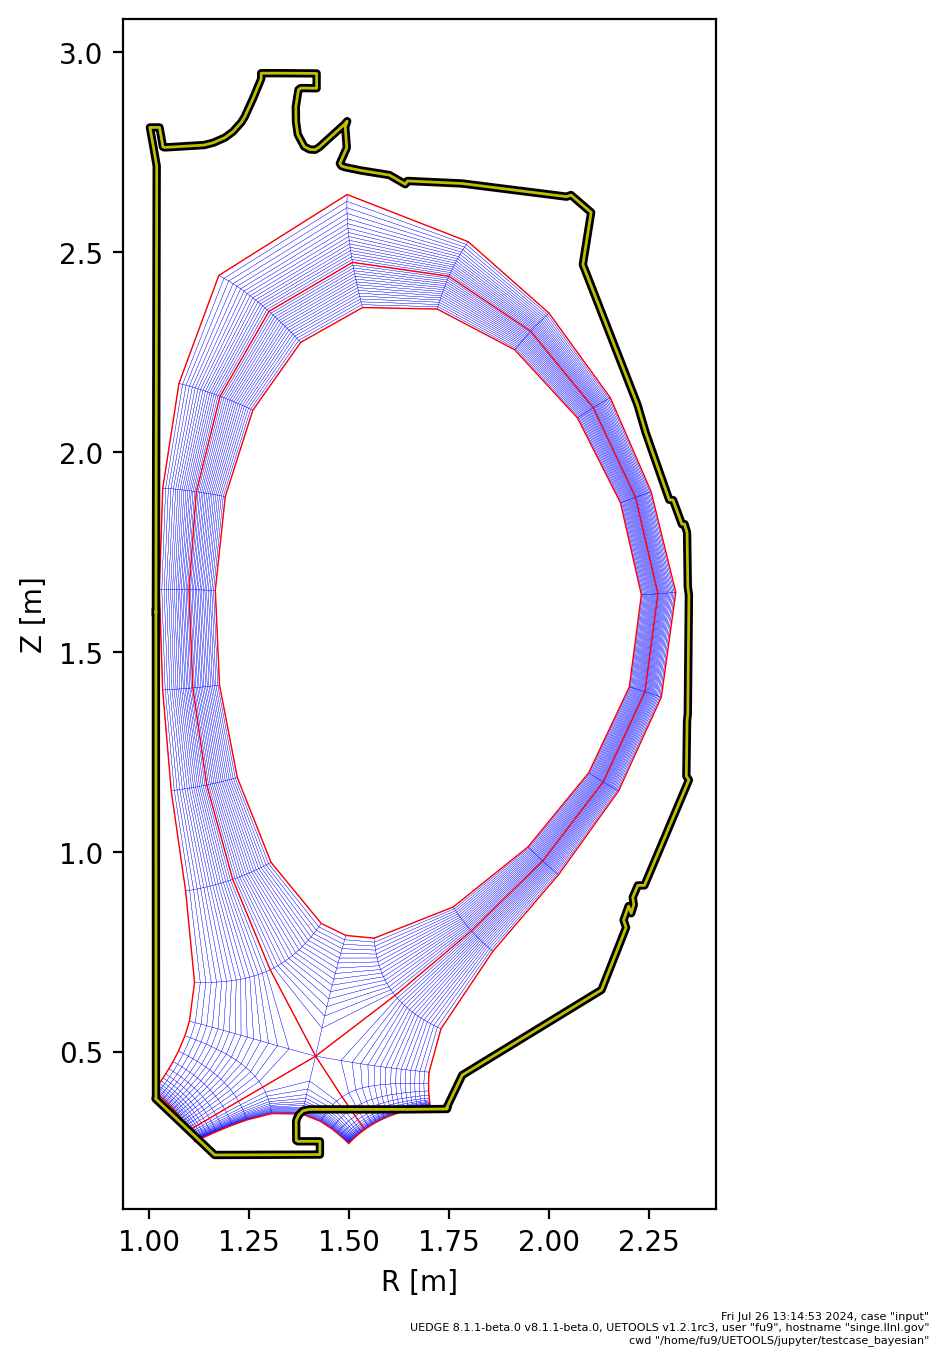

In [1]:
# Navigate to the example folder
from os import chdir
chdir('testcase_bayesian')
# Restore the case
from uetools import Case
c = Case('input.yaml')
c.grid(linewidth=0.1, 
       vessel=True, 
       plates=True, 
       lcfs=True, 
       lcfscolor='r', 
       linecolor='b'
      );

%config InlineBackend.figure_format = 'retina'

## Define criteria of Bayesian optimization  <a class="anchor" id="define_criteria"></a>

After setting up a Case, we need to tell the algorithm how to perform the Bayesian optimization. In other words, we need to define how to set up transport coeff, how to calculate equilibrium, and how to evaluate the descripency between UEDGE and observed profiles.

### 1. Define transport coefficients

In order for the black-box Bayesian optimization scheme to iteratively find the best fit, we need to tell it how to define the parameters in UEDGE. Therefore, one need to define the following function:

```python
def set_params(params, **kwargs):
    """
    A function acting as the interface between UEDGE and Bayesian optimization (BO). In each step, 
    BO algorithm will provide the next parameter(s) to evaluate. Then one can call this function
    to transform the next parameter(s) into UEDGE setting.
    
    Arguments:
    ----------
    params: np.array(N,) -- Required
        Each parameter BO provide is an np.array with N elements. Generally, they represents some 
        transport coefficients that needs to be defined on UEDGE grids. 
    **kwargs:
    """
```

In our current example, we can set the $\chi_\perp$ in SOL and pedestal regions as two constants to be infer, so we define the following function. For convenience, the transport coeff $\chi_\perp$ in the core and PF regions are pre-determined and assumed to be fixed.

In [2]:
import numpy as np
from uedge import bbb, com

# set chi_e in the pedestal and SOL region based on input params
def set_params(params=np.array([1.,1.]), **kwargs):
    
    from uedge import bbb, com
    
    # input is in log-scale
    kyeped, kyesol = 10.**(params)
    
    bbb.kye_use[com.ixpt1[0]+1:com.ixpt2[0]+1, 0:com.iysptrx+1] = 1.196 # core
    bbb.kye_use[0:com.ixpt1[0]+1,0:com.iysptrx+1] = 1. # PF
    bbb.kye_use[com.ixpt2[0]+1:com.nx+2,0:com.iysptrx+1] = 1. # PF
    
    bbb.kye_use[com.ixpt1[0]+1:com.ixpt2[0]+1, 12:17] = kyeped # pedestal
    bbb.kye_use[:,com.iysptrx+1:com.ny+2] = kyesol # SOL

We can see that $\chi_\perp$ has been devided into four spatial regions (core, pedestal, SOL, PF), where the values of $\chi_\perp$ in SOL and pedestal are the parameters we want to optimize.

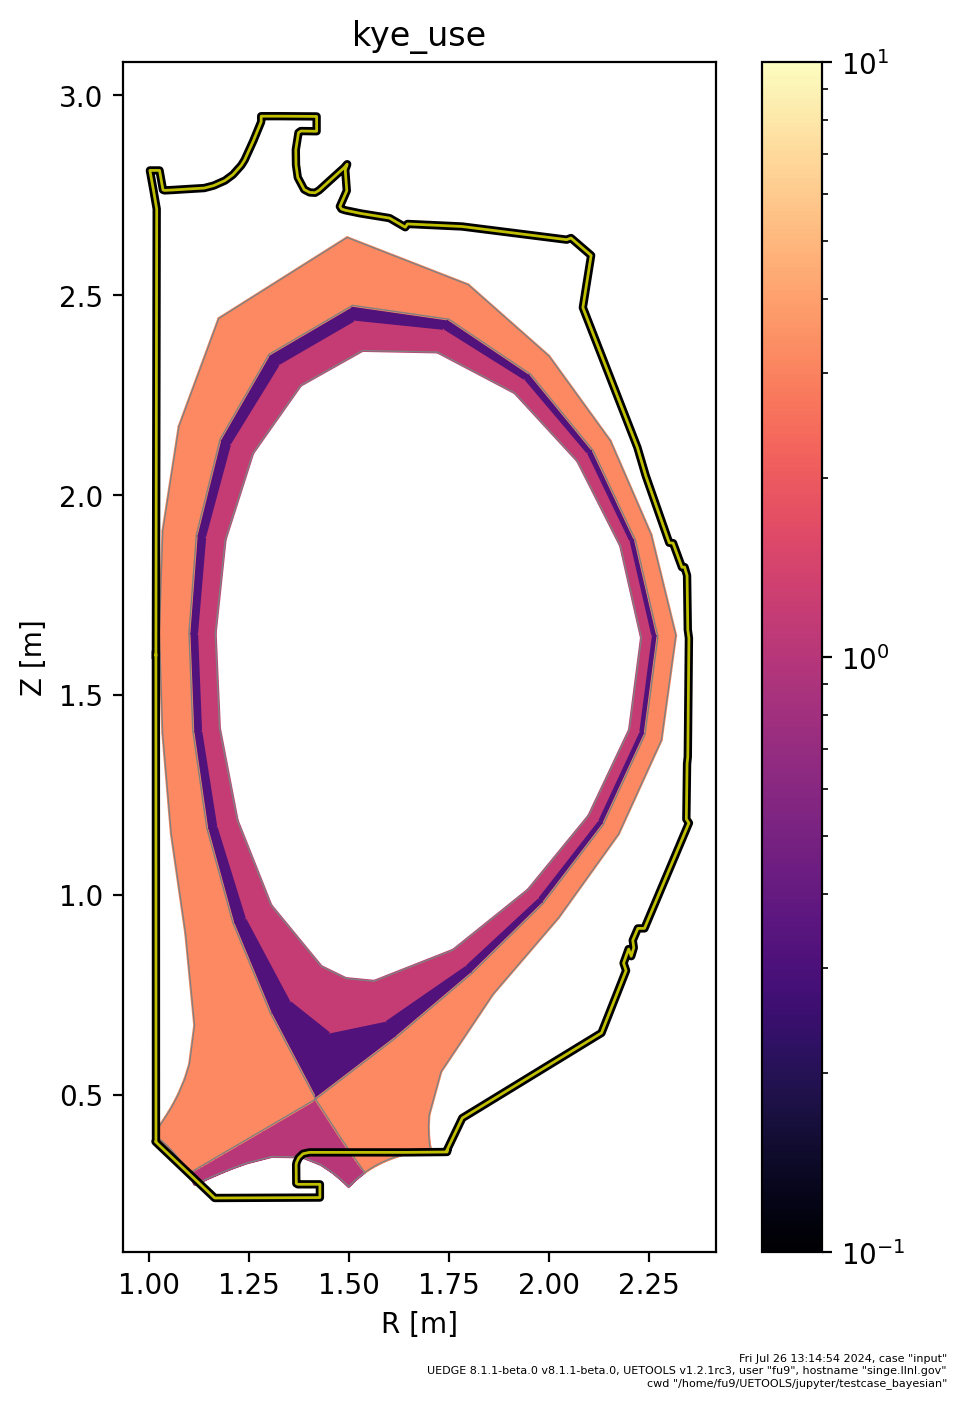

In [3]:
set_params(np.array([-0.5, 0.5]))
c.populate(verbose=False)
c.plotmesh(c.get('kye_use'), title='kye_use', log=True, zrange=[1e-1,1e1]);

### 2. Define equilibrium calculation

After telling the algorithm how to define parameters, we need to tell it how to calculate the equilibirum of `UEDGE` using the following function.
```python
def find_equilibrium(uetools_case, save_dir, **kwargs):
    """
    Defines the method to calculate an equilibrium.
    
    Arguments:
    ----------
    uetools_case: uetools.Case -- Required
        A uetools Case container to be converged.
    save_dir: String -- Required
        The location where HDF5 files are saved. The default is the current location.
    **kwargs:

    Return:
    -------
    convergence: boolean -- Required
        An indicator on whether such a case converges. 
    """
```

Because the Bayesian optimization algorithm will calculate a lot differenet parameters, we have to save all calculated cases into files for post-analysis. One also have to pass the `Case` object as input variable, and the function also has to return whether such case converges or not.

One simplest example using `Case().converge` is shown below.

In [4]:
def find_equilibrium(uetools_case: Case, save_dir='.', **kwargs):
    
    # converge the UEDGE case and save the result
    uetools_case.converge(savefname='{}/initial'.format(save_dir), ii1max=200)
    
    # return the convergence
    if uetools_case.get('iterm') == 1: return True
    else: return False

**Notice**: When the system is too big and complicated, `UEDGE` may fail to converge for the parameter given. If `UEDGE` only fails to converge for a small fraction of the parameter given, say 30\%, the algorithm can still run as normal. However, if the `UEDGE` fails too often, one might want to modify the function `find_equilibrium` to handle the failure.

### 3. Define the loss function

Finally, after getting the equilibrium for given paremter, one need to define a function to quantitatively evaluate the descripency between `UEDGE` result and given profiles. Such a function should be:

```python
def loss_function(**kwargs):
    """
    Defines how the loss function is defined, which will be minimized during 
    Bayesian optimization process. 
    
    Argumetns:
    ----------
    **kwargs

    Return:
    -------
    loss: float -- Required
    """
```

For simplicity, this example calculates the descripency in the mid-plane profile of $T_e$. Let the experimental profile located at $\{\psi_i\}$ with value $\{T_e(\psi_i)\}$ and measurment error $\{\sigma_i\}$, one can define the normalized mean-square error as:
\begin{align}
\chi^2 \doteq \dfrac{1}{N} \sum_{i=1}^N \left( \dfrac{T_{e}(\psi_i) - T_{e,\mathrm{UEDGE}}(\psi_i)}{\sigma_i} \right)^2.
\end{align}
We can define our loss function as the logarithm of chi-square: $\mathrm{loss}\doteq \log_{10}(\chi^2)$. 

In [5]:
# Read profile data from external files
import pickle 
with open('te_profile.pickle', 'rb') as handle:
   profile_data = pickle.load(handle)
   
te_val = profile_data['te_val']
te_psi = profile_data['te_psi']
te_err = profile_data['te_err']

In [6]:
# define loss function
def loss_function(**kwargs):
    
    from uedge import bbb, com
    
    # get psi_n and te from UEDGE
    psi_uedge = (com.psi[bbb.ixmp,:,0] - com.simagxs) / (com.sibdrys - com.simagxs)
    te_uedge = bbb.te[bbb.ixmp,:]/bbb.ev
    
    # interpolate UEDGE data to observed locations
    te_interpolated = np.interp(te_psi, psi_uedge, te_uedge, left=te_uedge[0], right=te_uedge[-1])
    
    # calculate mean-square-error
    return np.log10( np.sum( ((te_interpolated-te_val)/(te_err))**2. ) / len(te_val) )

### 4. (Optional) Define constraint and probability function

sometime, one want to make sure some quantities are varing with some range, but do not want to put them into loss functions. In those cases, one can define a constrain function as follows:

```python
def find_constraint(**kwargs):
    """
    (Optional) A function calculates the constrain of the system. In some situations, one may want to keep some 
    quantities within some range, but do not want to put them into the loss function. Those quantites can be the 
    constraint of the system.
    
    Argumetns:
    ----------
    **kwargs:
    """
```

If such constraint is defined, one need to pass a `scipy.optimize.NonlinearConstraint` object to the `bayes_opt` function as input. See [below]().

In addition, one can also define a probability function that translate the loss function to probability, which can be used to estimate the uncertainties in the Bayesian optimization. 
```python
def probability_function(loss, **kwargs):
    """
    (Optional) A function calculates probability for given loss function.
    
    Argumetns:
    ----------
    loss: float or np.array
        The value of the loss function
    **kwargs:
    """
```

When the loss is the mean-square error, the probability can be calculated as $P \doteq \exp( - \chi^2)$.

In [7]:
def probability_function(loss, **kwargs):
    
    return np.exp( - 10.**loss )

Finally, after all those function are define, one can create a class as a wrapper to include all four methods. Notice that the name of method has to be the same as the function. This class will be passed to `Case` for calculation.

In [8]:
class Physics:
    def __init__(self):
        self.set_params = set_params
        self.find_equilibrium = find_equilibrium
        self.loss_function = loss_function
        self.find_constraint = None
        self.probability_function = probability_function
        
physics = Physics()

# Begin Bayesian optimization <a class="anchor" id="bo"></a>

With all criteria defined, we are ready to proceed to Bayesian optimization. In `UETOOLS`, all methods related to Bayesian optimization can be accessed through `Case.bayes_optimizer`, which has to be initialized by the following method.

In [9]:
c.add_bayes_optimizer(physics=physics)

The Bayesian optimization can be accessed using `Case.bayes_optimizer.bayes_opt()`. After defining the boundary of inferred parameter, we can use Bayesian optimization to find the optimum choice.

(The calculated data is not included here.)


====== Begin initial sampling through quasi-Monte Carlo method =====

Current best:
target: -1.201090755567693
params: {'x0': -0.40690732561051846, 'x1': -1.719901123084128}

===== Begin Bayesian optimization =====

BO step 1 =====

Current best:
target: -1.1130824758258888
params: {'x0': -0.4615018891741874, 'x1': -2.0}

Time used: 2.54 mins

BO step 2 =====

Current best:
target: -1.1130824758258888
params: {'x0': -0.4615018891741874, 'x1': -2.0}

Time used: 3.57 mins

BO step 3 =====

Current best:
target: -1.1128653754714666
params: {'x0': -0.46633891539587086, 'x1': -1.9800890313372161}

Time used: 4.98 mins

BO step 4 =====

Current best:
target: -1.1128493830070254
params: {'x0': -0.4656865823875289, 'x1': -1.98229546254563}

Time used: 3.55 mins

===== Bayesian optimization conclusion =====

params: [-0.46568658 -1.98229546]
target: -1.1128493830070254
constraint: None
sub_dir: ./bayes_opt/80
uncertainty: [0.0148572  0.15181235]


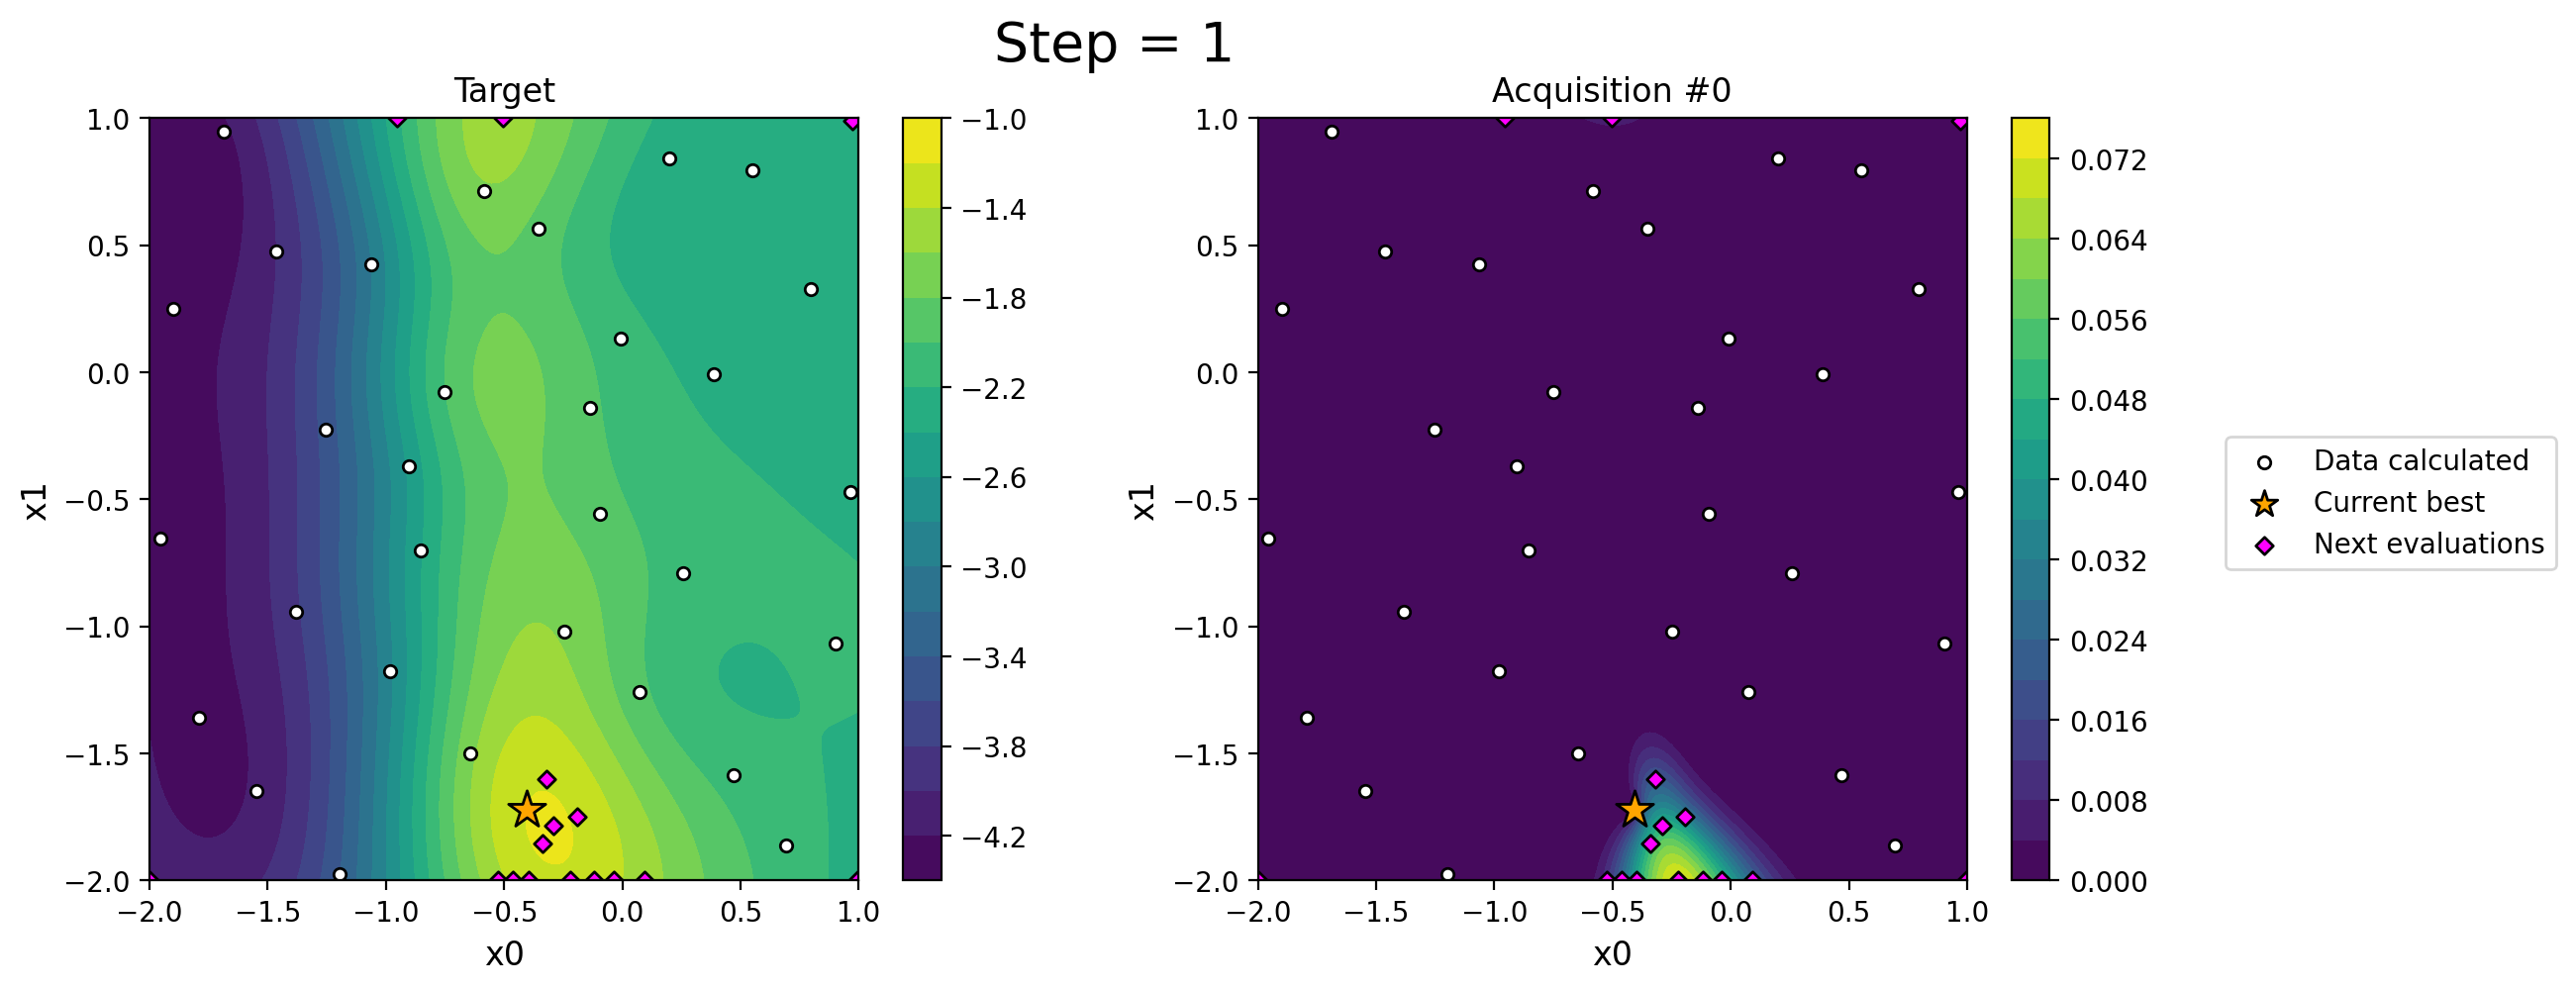

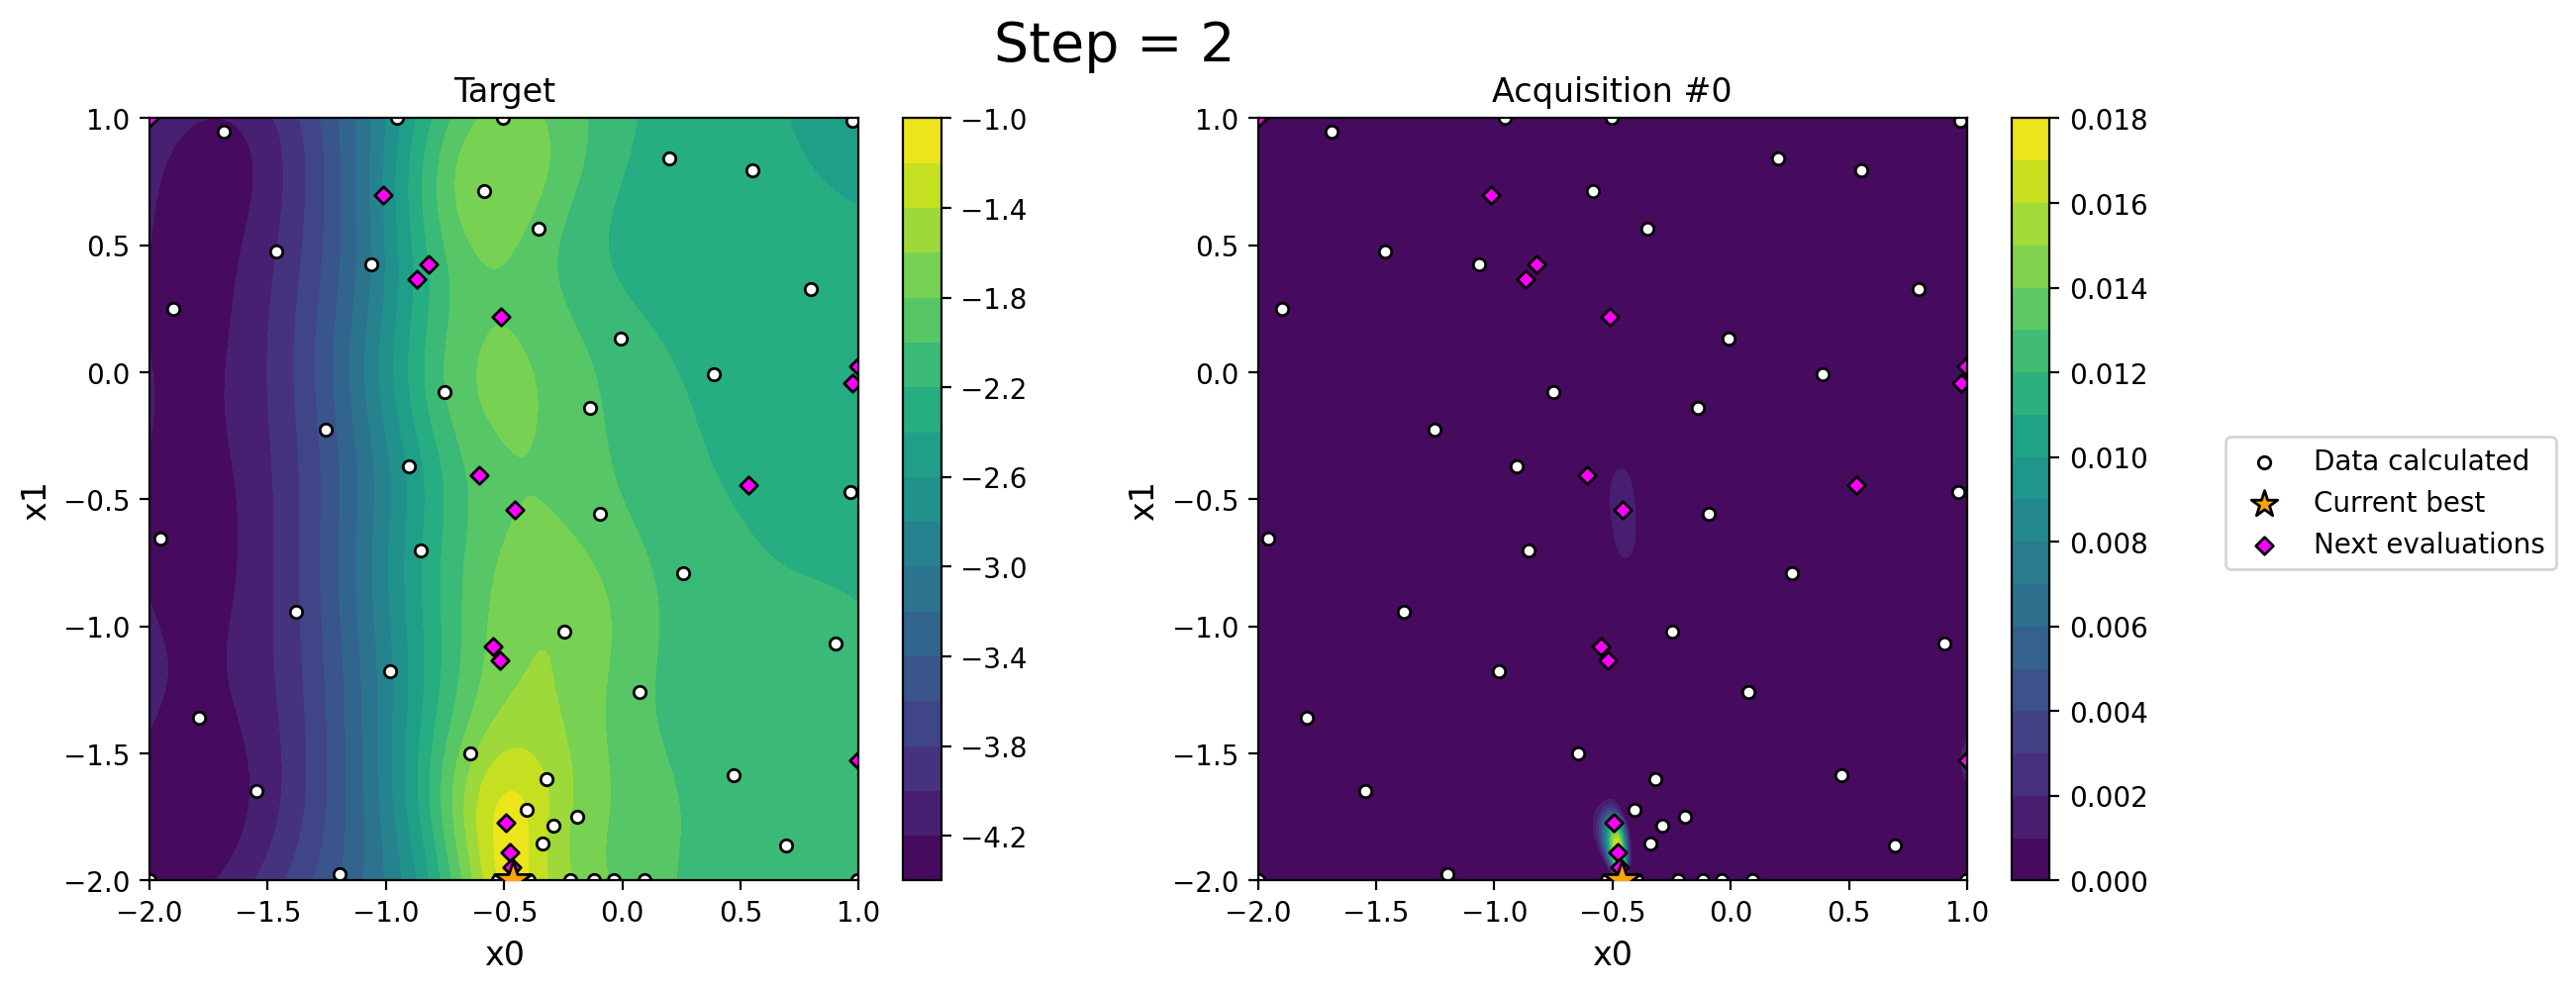

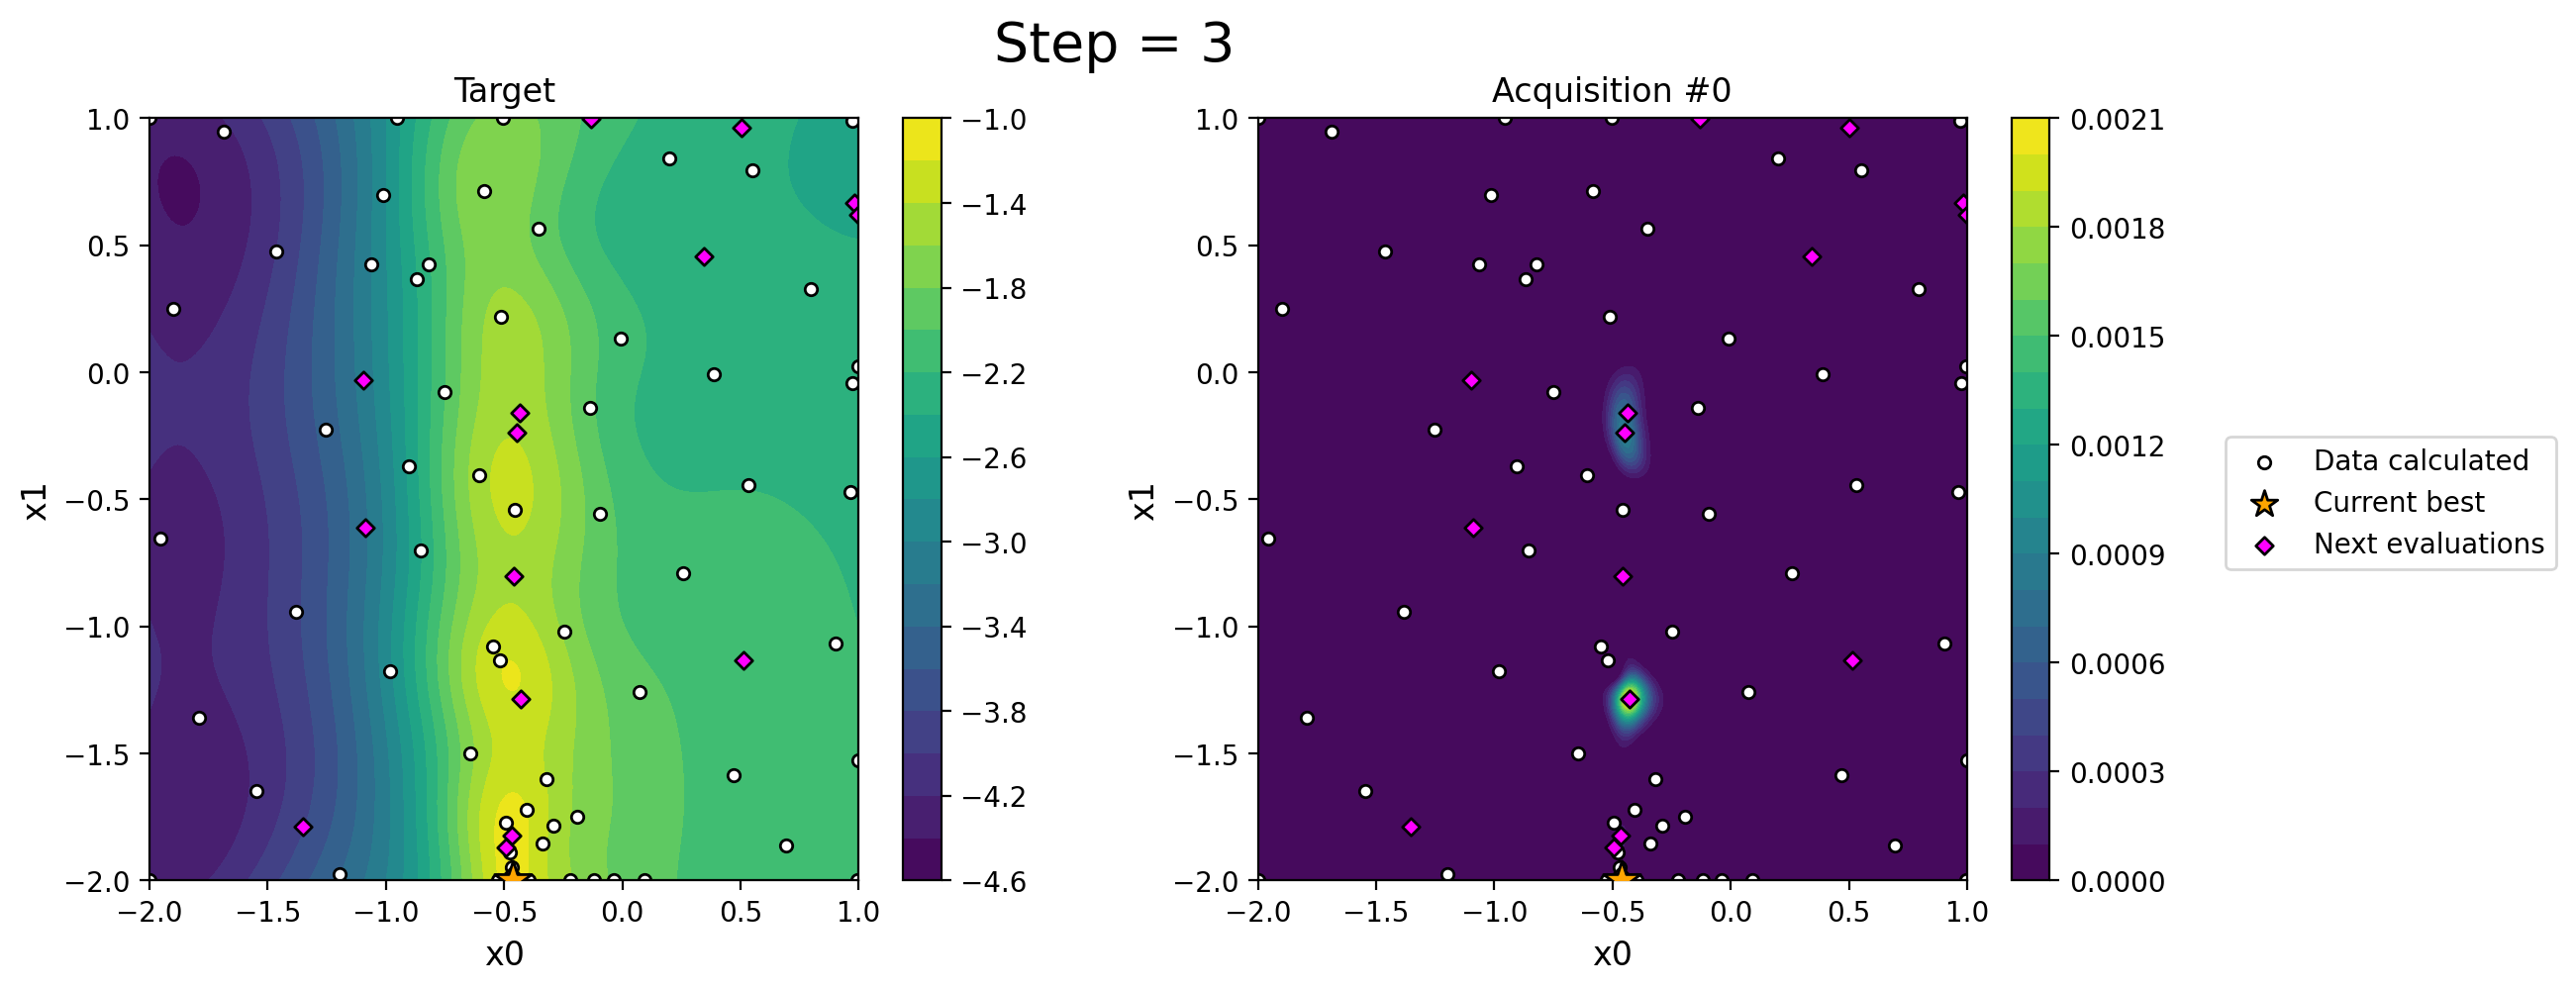

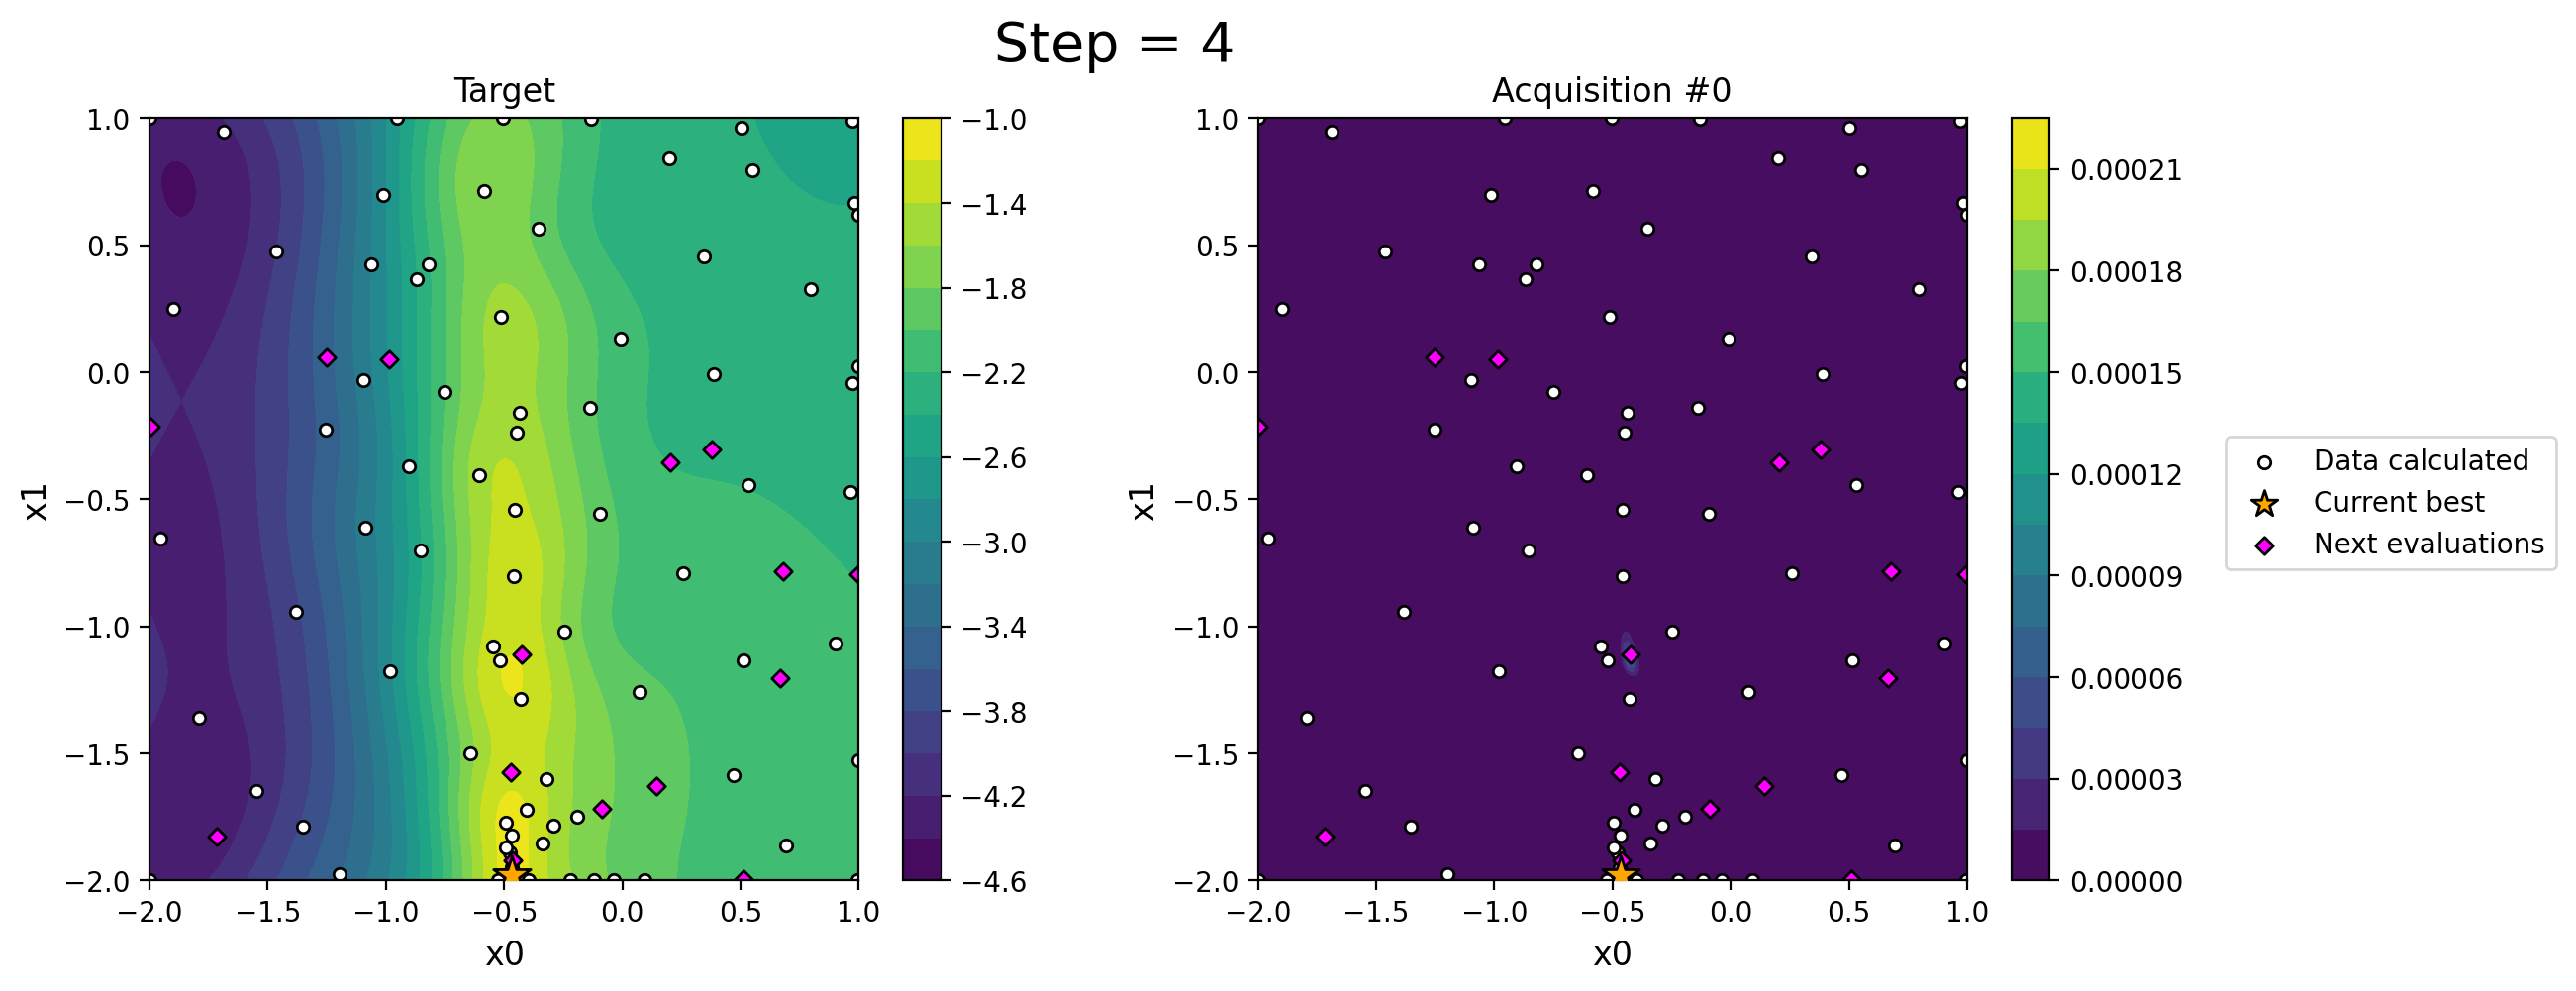

In [10]:
# set parameter boundary
param_bounds  = np.array([[-2., 1.],
                          [-2., 1.]])

# begin Bayesian optimization! 
bo_result = c.bayes_optimizer.bayes_opt(param_bounds = param_bounds,
                                        bo_steps = 4, # number Bayesian optimization iterations
                                        show_fig = True) # show figures

## Post analysis <a class="anchor" id="analysis"></a>

With the optimimum parameter found by Bayesian optimization, we can take a look at the Bayesian procedure and the final result.

In the 2-D parameter space, the countour of target value (which is defined as the minus of loss), and the acuisition function (#0) is shown below. White dots means data points evaluated, and the yellow star means our best parameter.

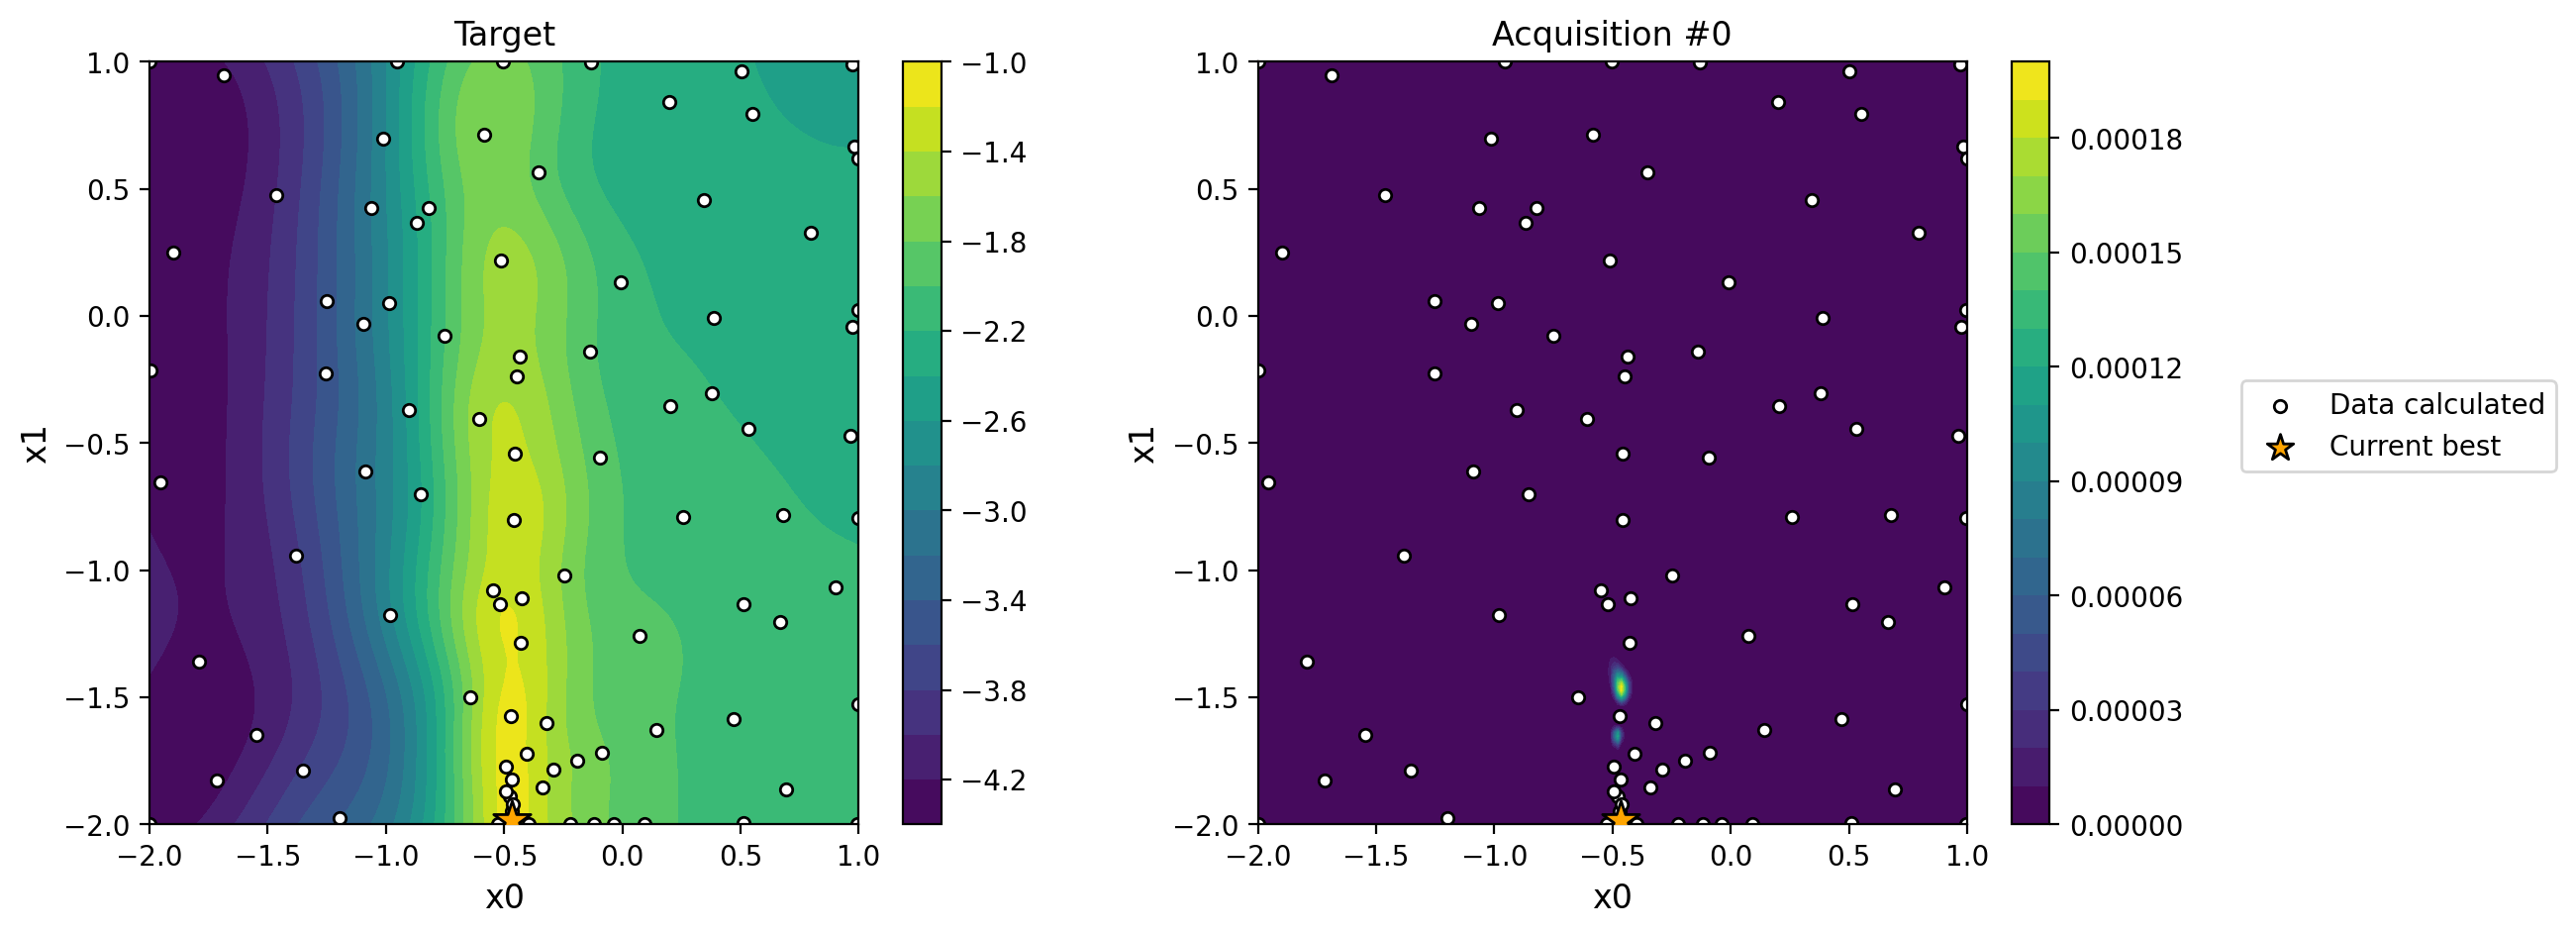

In [13]:
from uetools.UeBayesian.BayesUtility import plot_async_2D
plot_async_2D(param_bounds, c.bayes_optimizer.optimizer, c.bayes_optimizer.acq_functions[0])

Since we have defined the probability function, we can see the probability distribution in the 2-D parameter space. Based on the probability, we can also get the uncertainties from Bayesian optimization, which is defined as the standard deviation of the marginal distribution in each parameter. 

Here, we can see that our model fit $\chi_\mathrm{Ped}$ relatively well with small uncertainty. But the fitting for $\chi_\mathrm{SOL}$ is not as good, because it has larger uncertainty and it exceeds our estimated range $[10^{-2}, 10^1]$. A better estimation may be obtained if one include the parallel heat flux profile $q_\parallel$ in the loss function.

In [14]:
# grids on 2-D space
x = np.linspace(param_bounds[0,0], param_bounds[0,1], 200)
y = np.linspace(param_bounds[1,0], param_bounds[1,1], 200)
xy = np.array([[x_i, y_j] for y_j in y for x_i in x])
X, Y = np.meshgrid(x, y)

# Estimation of loss function
loss_est = - c.bayes_optimizer.optimizer._gp.predict(xy).reshape(X.shape)
P = probability_function(loss_est)
P_normalized = P / np.sum(P)

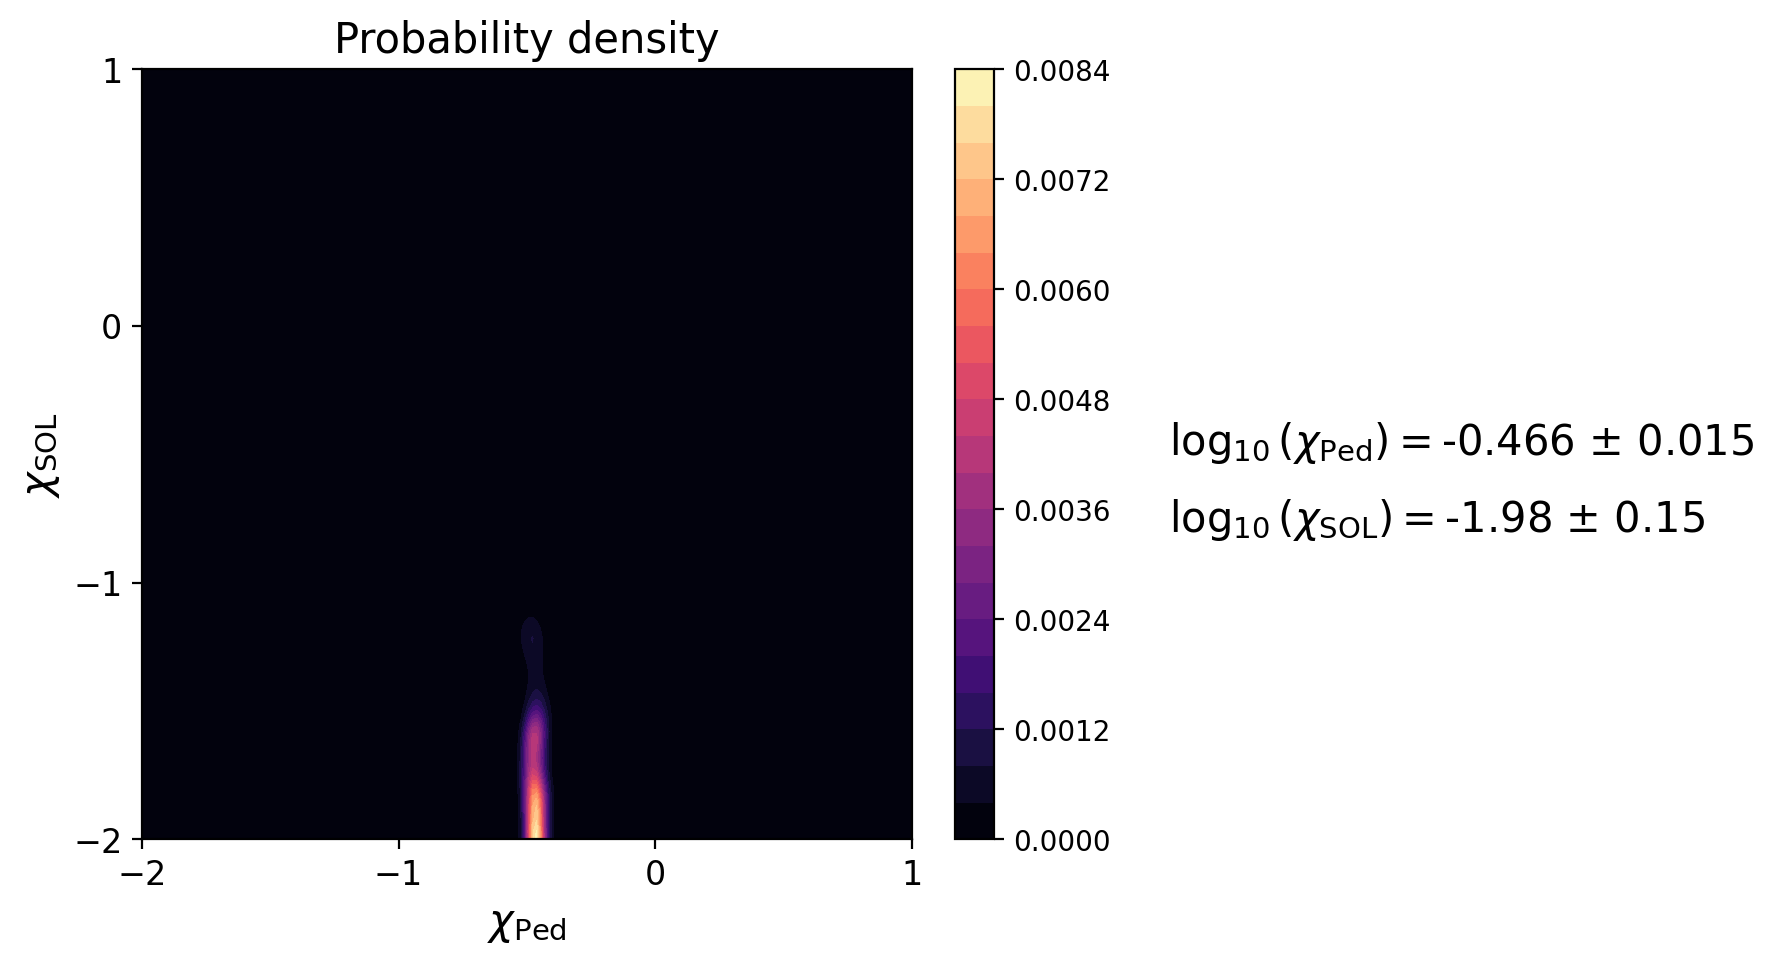

In [16]:
# plot probability distribution
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,5))
grid = fig.add_gridspec(ncols=2, nrows=1)
fig.subplots_adjust(wspace=0.5)

# Probability density
plt.contourf(X, Y, P_normalized, levels=20, cmap='magma')
plt.title('Probability density', fontsize=15);
plt.gca().set_aspect('equal')
plt.xlabel('$\chi_\mathrm{Ped}$', fontsize=15);
plt.xticks(np.linspace(-2,1,4), fontsize=12);
plt.ylabel('$\chi_\mathrm{SOL}$', fontsize=15);
plt.yticks(np.linspace(-2,1,4), fontsize=12);
plt.colorbar(fraction=0.046, pad=0.04)

plt.text(2,-0.5,'$\log_{10}(\chi_\mathrm{Ped})=$'+'{:.3f} $\pm$ {:.3f}'
         .format(bo_result['params'][0], bo_result['uncertainty'][0]), fontsize=15);
plt.text(2,-0.8,'$\log_{10}(\chi_\mathrm{SOL})=$'+'{:.2f} $\pm$ {:.2f}'
         .format(bo_result['params'][1], bo_result['uncertainty'][1]), fontsize=15);

We can further take a look at the profile from UEDGE at the best fit in comparision with experimental profile.

UETOOLS-style save successfully restored from ./bayes_opt/80/final.hdf5


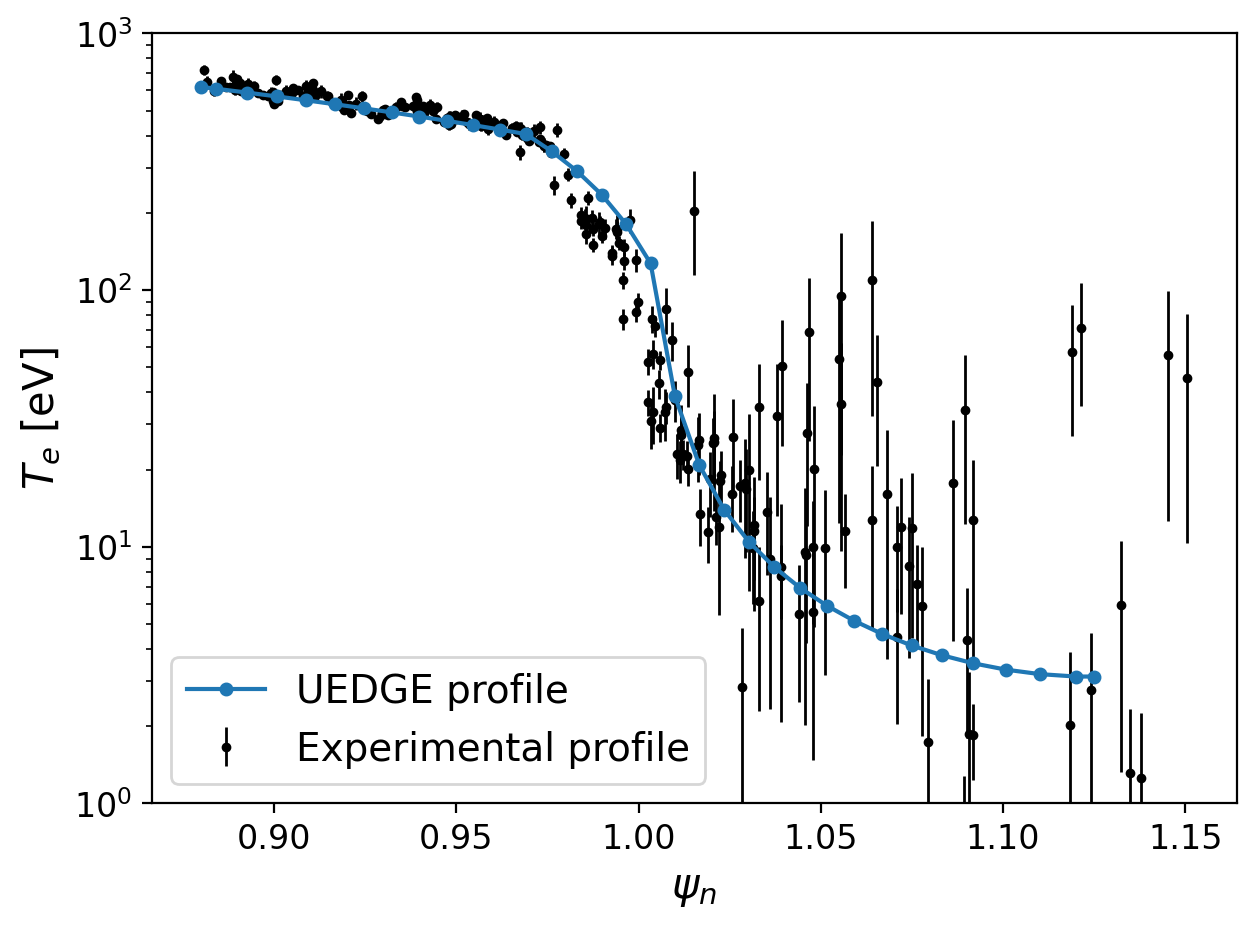

In [17]:
from uedge import bbb, com

# load save file from the best fit
c.restore_save('{}/final.hdf5'.format(bo_result['sub_dir']), verbose=False)

psi_uedge = (com.psi[bbb.ixmp,:,0] - com.simagxs) / (com.sibdrys - com.simagxs)
te_uedge = bbb.te[bbb.ixmp,:]/bbb.ev

plt.figure(figsize=(7,5))
plt.errorbar(te_psi, te_val, yerr = te_err, linewidth = 1., fmt='o', markersize=2.5, color='k', ecolor='k', 
             label = 'Experimental profile');
plt.plot(psi_uedge, te_uedge, 'o-', markersize=4, zorder=10, label='UEDGE profile')
plt.yscale('log');
plt.xlabel('$\psi_n$', fontsize=15); 
plt.xticks(fontsize=12);
plt.ylabel('$T_e$ [eV]', fontsize=15);
plt.yticks(fontsize=12); 
plt.ylim([1e0,1e3]);
plt.legend(fontsize=14, loc=3);